# Test the CORe50-Dataset on a simple model

Reproduce the baseline results 
- https://ieeexplore.ieee.org/document/8793982
- https://github.com/tyler-hayes/ExStream

In [9]:
import pathlib
import torch
import time
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50, resnet18, ResNet18_Weights
import torchvision
import PIL.Image
import pandas as pd
from utils import seed_everything

In [11]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [10]:
EPOCHS = 128
DEVICE = 'mps'
DATA_DIR = pathlib.Path('/Users/marwei/Datasets/encodedgdumb')
BATCH_SIZE = 256
pretraining_classes = [0, 1]
seed_everything(0)

In [12]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])


trainset_full = CIFAR10(
    train=True,
    transform=train_transforms,
    root=DATA_DIR,
    download=True
)
train_subset_idxs = [i for i in range(len(trainset_full)) if trainset_full.targets[i] in pretraining_classes]
trainset = torch.utils.data.Subset(trainset_full, train_subset_idxs)

testset_full = CIFAR10(
    train=False,
    transform=test_transforms,
    root=DATA_DIR,
    download=True
)
test_subset_idxs = [i for i in range(len(testset_full)) if testset_full.targets[i] in pretraining_classes]
testset = torch.utils.data.Subset(testset_full, test_subset_idxs)

trainloader = DataLoader(
    dataset=trainset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
)
testloader = DataLoader(
    dataset=testset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
model = resnet18().to(DEVICE)
model.fc = torch.nn.Linear(in_features=512, out_features=10, device=DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4,
)


In [14]:
def test_model(model, dataloader, criterion, device):
    with torch.no_grad():
        running_loss = 0
        running_acc = 0
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)

            prob = torch.nn.functional.softmax(output, dim=1)
            pred = torch.argmax(prob, dim=1)
            corr = torch.eq(pred, target)
            acc = (corr*1.0).mean()

            running_acc += acc.item()
            running_loss += loss.item()

    return (
        running_acc/len(dataloader),
        running_loss/len(dataloader),
    )

Train the model

In [15]:
for data, target in trainloader:
    assert torch.logical_or(target==0, target==1).all().item()
for data, target in testloader:
    assert torch.logical_or(target==0, target==1).all().item()

In [16]:
print('starting testing')
model.eval()
tstart = time.time()
acc, loss = test_model(
    model=model,
    dataloader=testloader,
    criterion=criterion,
    device=DEVICE
)
testtimes = [time.time()-tstart]
testlosses = [loss]
testaccs = [acc]
trainlosses = [loss]
trainaccs = [0]
traintimes = [0]
checkpoints = []
best_acc = 0
print(f"epoch {0}\t testloss {testlosses[-1]:.4f} \f testacc {testaccs[-1]:.4f}\t time {testtimes[-1]:.0f} s")

# training
for epoch in range(EPOCHS):
    running_loss = 0
    running_acc = 0
    tstart = time.time()
    model.train()
    for data, target in trainloader:
        data = data.to(DEVICE)
        target = target.to(DEVICE)

        # output = model(embedding)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        prob = torch.nn.functional.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1)
        corr = torch.eq(pred, target)
        acc = (corr*1.0).mean()
        running_acc += acc.item()
        running_loss += loss.item()

    traintimes.append(time.time() - tstart)
    trainlosses.append(running_loss / len(trainloader))
    trainaccs.append(running_acc / len(trainloader))

    print(f"epoch {epoch+1}\t trainloss {trainlosses[-1]:.4f} \f trainacc {trainaccs[-1]:.4f}\t time {traintimes[-1]:.0f} s")

    # testing
    model.eval()
    running_loss = 0
    running_acc = 0
    tstart = time.time()
    acc, loss = test_model(
        model=model,
        dataloader=testloader,
        criterion=criterion,
        device=DEVICE
    )
    testtimes.append(time.time()-tstart)
    testlosses.append(loss)
    testaccs.append(acc)

    if acc > best_acc:
        path = f"resnet18_cifar10_classes01_e{epoch+1}.pt"
        torch.save(model.state_dict(), path)
        checkpoints.append(epoch+1)
        best_acc = acc
        print(f"saved checkpoint: {path}")

    print(f"epoch {epoch+1}\t testloss {testlosses[-1]:.4f} \t testacc {testaccs[-1]:.4f}\t time {testtimes[-1]:.0f} s")

starting testing
epoch 0	 testloss 2.1084  testacc 0.4963	 time 24 s
epoch 1	 trainloss 0.5024  trainacc 0.7869	 time 27 s
saved checkpoint: resnet18_cifar10_classes01_e1.pt
epoch 1	 testloss 0.3741 	 testacc 0.8573	 time 23 s
epoch 2	 trainloss 0.3066  trainacc 0.8788	 time 26 s
epoch 2	 testloss 0.3326 	 testacc 0.8531	 time 23 s
epoch 3	 trainloss 0.1866  trainacc 0.9241	 time 27 s
saved checkpoint: resnet18_cifar10_classes01_e3.pt
epoch 3	 testloss 0.2099 	 testacc 0.9175	 time 24 s
epoch 4	 trainloss 0.1077  trainacc 0.9601	 time 27 s
epoch 4	 testloss 0.2581 	 testacc 0.9130	 time 23 s
epoch 5	 trainloss 0.1526  trainacc 0.9431	 time 27 s
epoch 5	 testloss 0.2452 	 testacc 0.9109	 time 23 s
epoch 6	 trainloss 0.1922  trainacc 0.9220	 time 27 s
saved checkpoint: resnet18_cifar10_classes01_e6.pt
epoch 6	 testloss 0.2089 	 testacc 0.9197	 time 23 s
epoch 7	 trainloss 0.0957  trainacc 0.9649	 time 26 s
epoch 7	 testloss 0.3206 	 testacc 0.9049	 time 23 s
epoch 8	 trainloss 0.

Text(0.5, 1.0, 'Accuracy')

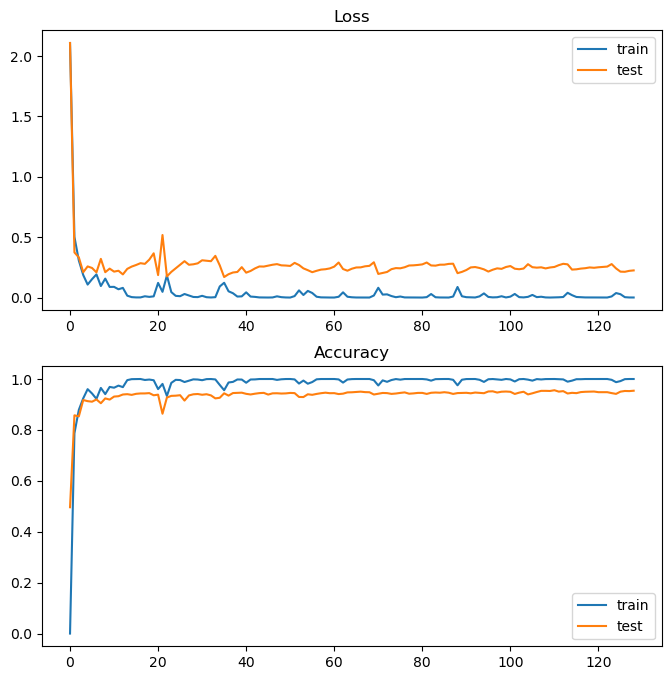

In [25]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

ax1.plot(list(range(EPOCHS+1)), trainlosses, label='train')
ax1.plot(list(range(EPOCHS+1)), testlosses, label='test')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(list(range(EPOCHS+1)), trainaccs, label='train')
ax2.plot(list(range(EPOCHS+1)), testaccs, label='test')
ax2.legend()
ax2.set_title('Accuracy')